## Leukocytes Image Classification with <b>MONAI DenseNet121</b> and Pytorch Lightning⚡
![img](https://docs.monai.io/projects/monai-deploy-app-sdk/en/0.2.1/_static/MONAI-logo-color.png)
***
Computer vision project _Leukocytes classification from blood smear images - LCBSI_


The notebook author: @AgataPolejowska

### 🔨 📁 Setup the environment - install and import essential packages

It is recommended to run the notebook within `lcbsi` environment created using the `environment.yml` file provided in the root directory of the project. The instructions for installing the environment are contained in `README.md` file.

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
!python -c "import wandb" || pip install -q wandb
!pip install roboflow --quiet

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 1.2 MB 18.0 MB/s 
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'wandb'
     |████████████████████████████████| 1.9 MB 4.8 MB/s 
     |████████████████████████████████| 182 kB 29.3 MB/s 
     |████████████████████████████████| 168 kB 57.3 MB/s 
     |████████████████████████████████| 62 kB 482 kB/s 
     |████████████████████████████████| 168 kB 17.7 MB/s 
     |████████████████████████████████| 166 kB 28.9 MB/s 
     |████████████████████████████████| 166 kB 58.4 MB/s 
     |████████████████████████████████| 162 kB 46.0 MB/s 
     |████████████████████████████████| 162 kB 19.9 MB/s 
     |████████████████████████████████| 158 kB 31.5 MB/s 
     |████████████████████████████████| 157 kB 13.7 MB/s 
     |████████████████████████████████| 157 kB 71.4 MB/s 
     |█████

In [2]:
!pip install -U -q torch
!pip install -U -q torchvision==0.14.0

     |██████████████████████████████  | 834.1 MB 1.2 MB/s eta 0:00:49tcmalloc: large alloc 1147494400 bytes == 0x662fe000 @  0x7f2ab798d615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |████████████████████████████████| 890.2 MB 6.1 kB/s 
     |████████████████████████████████| 317.1 MB 33 kB/s 
     |████████████████████████████████| 557.1 MB 12 kB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 849 kB 48.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.13.0 which is incompatible.
torchtext 0.13.1 requires 

In [3]:
!python -c "import torchmetrics" || pip install -q torchmetrics

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'torchmetrics'
     |████████████████████████████████| 512 kB 24.8 MB/s 


In [4]:
!python -c "import pytorch_lightning" || pip install -q pytorch-lightning

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'pytorch_lightning'
     |████████████████████████████████| 798 kB 26.9 MB/s 
     |████████████████████████████████| 125 kB 64.2 MB/s 
     |████████████████████████████████| 87 kB 7.5 MB/s 


In [5]:
!python -c "import plotly" || pip install -q plotly

In [6]:
import torch
import torchvision
import torchmetrics

print(torch.__version__)
print(torchvision.__version__)
print(torchmetrics.__version__)

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

1.13.0+cu117
0.14.0+cu117
0.11.0


In [7]:
import pytorch_lightning as pl

print(pl.__version__)

1.8.3.post1


In [8]:
from roboflow import Roboflow

In [9]:
import os
from pathlib import Path
import PIL
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [10]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

sns.set_style()

In [11]:
import monai
from monai.config import print_config
from monai.data import DataLoader
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Compose,
)
from monai.utils import set_determinism
from monai.visualize import GradCAM, CAM
from monai.optimizers import LearningRateFinder

In [12]:
print_config()

MONAI version: 1.1.dev2249
Numpy version: 1.21.6
Pytorch version: 1.13.0+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6ac8fa0b0d0f475a8cceea86b12e448c19aeb050
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.0+cu117
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### 📣📉📈 Configure W&B for results monitoring
![img](https://raw.githubusercontent.com/wandb/assets/main/wandb-logo-yellow-dots-black-wb.svg)


Weight and Biases are used as a MLOps platform in order to track the experiments results.

This notebook runs are configured to be viewed here: _https://wandb.ai/polejowska/lcbsi-monai-pl_

In [13]:
import wandb

wandb.login()

PROJECT = "lcbsi-monai-pl"
ENTITY = "polejowska"

wandb.init(project=PROJECT, entity=ENTITY)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin


In [14]:
from pytorch_lightning.callbacks import Callback, EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger


wandb_logger = WandbLogger(project=PROJECT, log_model="all", score="accuracy")

class ImagePredictionLogger(Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples


early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max')

Providing log_model=all requires wandb version >= 0.10.22 for logging associated model metadata.
Hint: Upgrade with `pip install --upgrade wandb`.


### 🌱 Ensure results reproducibility by setting the seed for MONAI and Pytorch Lightning

In [15]:
set_determinism(seed=0)
pl.seed_everything(0)

INFO:lightning_lite.utilities.seed:Global seed set to 0


0

### 🔧🔒 Create Pytorch Lightning DataModule - LeukocytesDataModule

This module is created so that all the steps needed to process data are encapsulated and easily reusable.

Within this module the following can be performed:
- setting up the dataset by dowloading it from Roboflow
- getting essential information about the dataset
- visualizing sample images from the dataset
- logging to wandb information about the dataset
- <b>getting dataloaders<b>

In [16]:
class LeukocytesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int = 32,
        num_workers: int = 12,
        num_classes: int = 5,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_workers = num_workers

    def setup(self, version_number=5):
        rf = Roboflow(api_key="3a7r2eyLT0LA2P5AUyvr")
        self.project = rf.workspace("lcbsiwbc").project("lcbsi-ds")
        dataset = self.project.version(version_number).download("folder")
        self.data_dir = dataset.location
        print(f"Dataset downloaded to {self.data_dir}")
        self.path_to_dataset = Path(self.data_dir)

    def get_info_about_dowloaded_dataset(self):
        version_information = self.project.get_version_information()
        version = version_information[0]
        print(f"Dataset name: {version['name']}")
        print(f"Dataset ID: {version['id']}")
        print(f"Dataset splits: {version['images']}")
        print(f"Dataset splits: {version['splits']}")
        print(f"Dataset augmentations: {version['augmentation']}")
        print(f"Dataset preprocessing: {version['preprocessing']}")
        wandb.config.update(
            {
                "dataset_name": version["name"],
                "dataset_id": version["id"],
                "dataset_splits": version["images"],
                "dataset_splits": version["splits"],
                "dataset_augmentations": version["augmentation"],
                "dataset_preprocessing": version["preprocessing"],
            }
        )

    def visualize_dataset(self):
        test_files = []
        for name in self.class_names:
            test_files.extend(
                [
                    os.path.join(self.data_dir, "test", name, x)
                    for x in os.listdir(os.path.join(self.data_dir, "test", name))
                ]
            )
        print(f"Number of test files: {len(test_files)}")

        with PIL.Image.open(test_files[0]) as img:
            img_size = img.size
        print(f"Image size: {img_size}")

        test_files = np.random.choice(test_files, 9, replace=False)
        _, axes = plt.subplots(3, 3, figsize=(12, 12))
        for i, file in enumerate(test_files):
            with PIL.Image.open(file) as img:
                ax = axes[i // 3, i % 3]
                ax.set_title(os.path.basename(os.path.dirname(file)))
                ax.imshow(img)
                ax.axis("off")
                wandb.log({f"test_images_{i}": wandb.Image(img)})
        plt.tight_layout()
        plt.show()

    def get_classes_info(self):
        self.class_names = sorted(
            [
                name
                for name in os.listdir(os.path.join(self.data_dir, "test"))
                if os.path.isdir(os.path.join(self.data_dir, "test", name))
            ]
        )
        num_classes = len(self.class_names)
        print(f"Class names: {self.class_names} ({num_classes} classes)")

    def train_dataloader(self, train_transforms):
        self.train_dataset = ImageFolder(
            self.path_to_dataset / "train", train_transforms
        )
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self, val_transforms):
        self.val_dataset = ImageFolder(self.path_to_dataset / "valid", val_transforms)
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self, val_transforms):
        self.test_dataset = ImageFolder(self.path_to_dataset / "test", val_transforms)
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def log_module_data_to_wb(self):
        wandb.config.update(
            {
                "data_module_config": {
                    "data_dir": self.data_dir,
                    "batch_size": self.batch_size,
                    "num_classes": self.num_classes,
                    "num_workers": self.num_workers,
                }
            }
        )

In [17]:
NUM_CLASSES = 5
BATCH_SIZE = 32
DATASET_VERSION_NUMBER = 5

In [18]:
leukocytes_data_module = LeukocytesDataModule(batch_size=BATCH_SIZE, num_classes=NUM_CLASSES)
leukocytes_data_module.setup(version_number=DATASET_VERSION_NUMBER)
leukocytes_data_module.log_module_data_to_wb()

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to LCBSI-DS-5 in folder:: 100%|██████████| 3995/3995 [00:00<00:00, 8414.43it/s]

Dataset downloaded to /content/LCBSI-DS-5


In [19]:
leukocytes_data_module.get_classes_info()

Class names: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil'] (5 classes)


In [20]:
leukocytes_data_module.get_info_about_dowloaded_dataset()

Dataset name: 2022-12-04 11:27am
Dataset ID: lcbsiwbc/lcbsi-ds/6
Dataset splits: 3982
Dataset splits: {'valid': 500, 'test': 500, 'train': 2982}
Dataset augmentations: {'flip': {'horizontal': True, 'vertical': True, 'enabled': True}, 'saturation': {'enabled': True, 'percent': 33}, 'image': {'versions': 3, 'enabled': True}}
Dataset preprocessing: {'resize': {'format': 'Stretch to', 'height': '256', 'width': '256', 'enabled': True}}


Number of test files: 495
Image size: (256, 256)


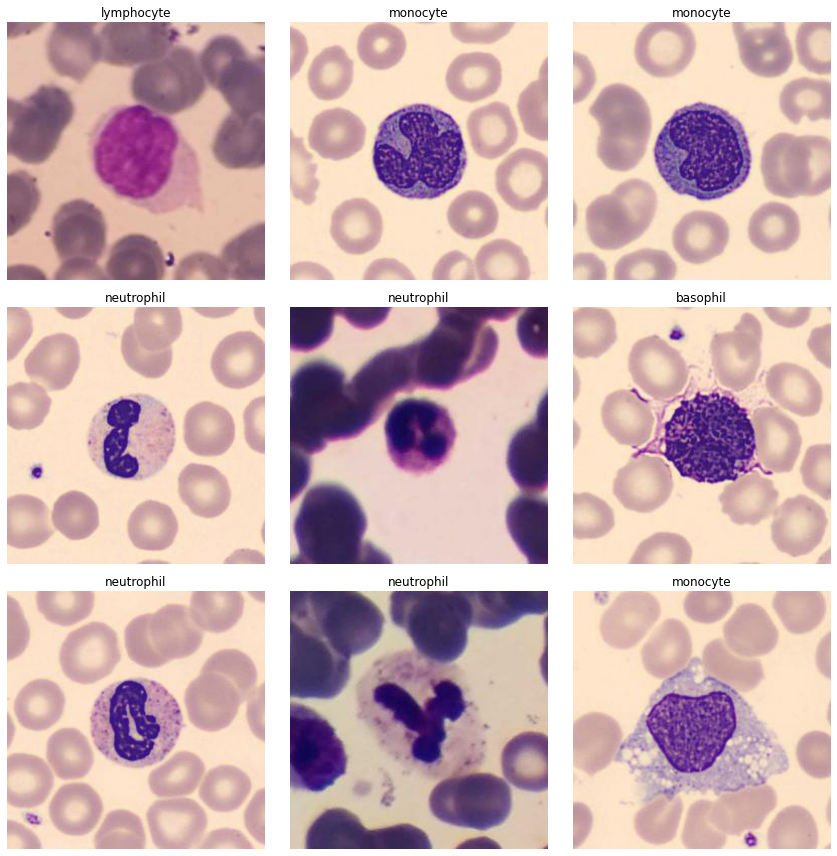

In [21]:
leukocytes_data_module.visualize_dataset()

In [22]:
TRANSFORMS = Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [23]:
train_loader = leukocytes_data_module.train_dataloader(TRANSFORMS)
val_loader = leukocytes_data_module.val_dataloader(TRANSFORMS)
test_loader = leukocytes_data_module.test_dataloader(TRANSFORMS)

### 🔧🎺 Create Pytorch Lightning Module - Model

This class organizes the code into the most important sections: computations, train loop, validation loop, test loop, prediction loop, optimizers.<br>

In [33]:
class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        # self.accuracy = torchmetrics.Accuracy # vscode env
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=5) # colab env
        self.gradcam = monai.visualize.GradCAM(
            self.net, target_layers="class_layers.relu"
        )
        self.cam = monai.visualize.CAM(
            self.net, target_layers="class_layers.relu", fc_layers="class_layers.out"
        )

    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        return optimizer

    def prepare_batch(self, batch):
        x, y = batch
        return x.to("cpu"), y.to("cpu")

    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_acc", acc, prog_bar=True, logger=True)
        return loss

### 🔩📏 Configure the model

1. Model DenseNet121 is initialized using MONAI framework.
2. Pretrained model from _https://github.com/Project-MONAI/model-zoo/releases/tag/hosting_storage_v1_ (_https://github.com/Project-MONAI/model-zoo/tree/dev/models/pathology_nuclei_classification_) is downloaded.
3. First layer and last layers of the pretrained model is adjusted to the corresponding layers in created DenseNet121 model to avoid size mismatch errors regarding input channels number and output channels.
4. Parameters and buffers are coppied from pretrained model to created DenseNet121.
5. All layers from denseblock1 to denseblock3 inclusive are frozen so that they won't be trained. The rest of the layers are trained ensuring the model learns to classify leukocytes.

In [34]:
IN_CHANNELS = 3
SPATIAL_DIMS = 2
PRETRAINED = False

model_DenseNet121 = DenseNet121(
    pretrained=PRETRAINED, in_channels=IN_CHANNELS, out_channels=NUM_CLASSES, spatial_dims=SPATIAL_DIMS
)

In [35]:
pretrained_model = monai.bundle.load(
    name="pathology_nuclei_classification", bundle_dir="./", version="0.0.1"
)

pretrained_model["features.conv0.weight"] = model_DenseNet121.features.conv0.weight
pretrained_model["class_layers.out.weight"] = model_DenseNet121.class_layers.out.weight
pretrained_model["class_layers.out.bias"] = model_DenseNet121.class_layers.out.bias

model_DenseNet121.load_state_dict(pretrained_model)

<All keys matched successfully>

In [36]:
for param in model_DenseNet121.features.denseblock1.parameters():
    param.requires_grad = False

for param in model_DenseNet121.features.transition1.parameters():
    param.requires_grad = False

for param in model_DenseNet121.features.denseblock2.parameters():
    param.requires_grad = False

for param in model_DenseNet121.features.transition2.parameters():
    param.requires_grad = False

for param in model_DenseNet121.features.denseblock3.parameters():
    param.requires_grad = False

for param in model_DenseNet121.features.transition3.parameters():
    param.requires_grad = False

In [37]:
for param in model_DenseNet121.features.denseblock4.parameters():
    param.requires_grad = True

for param in model_DenseNet121.features.norm5.parameters():
    param.requires_grad = True

for param in model_DenseNet121.class_layers.parameters():
    param.requires_grad = True

### 🔎 Use LearningRateFinder from MONAI to set the optimal learning rate for training

In [38]:
def get_optimal_learning_rate(model, train_loader, val_loader, criterion):
    lower_lr, upper_lr = 1e-5, 1e-0
    optimizer = torch.optim.Adam(model.parameters(), lower_lr)
    lr_finder = LearningRateFinder(model, optimizer, criterion, device='cpu')
    lr_finder.range_test(train_loader, val_loader, end_lr=upper_lr, num_iter=20)
    steepest_lr, _ = lr_finder.get_steepest_gradient()
    lr_finder.plot()
    return steepest_lr

### 🔧 Create the Pytorch Lightning Model ⚡ with pretrained model from MONAI 🌐


In [39]:
OPTIMIZER_CLASS = torch.optim.Adam
CRITERION = torch.nn.CrossEntropyLoss()
# LEARNING_RATE = get_optimal_learning_rate(
#     model_DenseNet121, train_loader, val_loader, CRITERION
# )

# print(f"Optimal learning rate: {LEARNING_RATE}")

In [40]:
LEARNING_RATE = 6.158482110660263e-05

In [41]:
model = Model(model_DenseNet121, CRITERION, LEARNING_RATE, OPTIMIZER_CLASS)

In [42]:
wandb.config.update(
    {
        "pretrained_model_name": "pathology_nuclei_classification",
        "pretrained_model_version": "0.0.1",
        "model_architecture": str(model_DenseNet121),
        "optimizer": str(OPTIMIZER_CLASS),
        "criterion": str(CRITERION),
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
    }
)

wandb.watch(model)

[]

In [43]:
val_samples = next(iter(test_loader))

### 🚅💪 Train the model using Pytorch Lightning ⚡

In [44]:
CALLBACKS = [ImagePredictionLogger(val_samples), checkpoint_callback]
MAX_EPOCHS = 2
LOG_EVERY_N_STEPS = 1

In [45]:
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=wandb_logger,
    callbacks=CALLBACKS,
    log_every_n_steps=LOG_EVERY_N_STEPS,
)

Can't initialize NVML
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [46]:
model_trained = trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | net       | DenseNet121        | 7.0 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
2.2 M     Trainable params
4.8 M     Non-trainable params
7.0 M     Total params
27.836    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [47]:
wandb.config.update(
    {
        "trainable_parameters": sum(
            p.numel() for p in model_DenseNet121.parameters() if p.requires_grad
        ),
        "non_trainable_parameters": sum(
            p.numel() for p in model_DenseNet121.parameters() if not p.requires_grad
        ),
    }
)

### 🎯🏆 Test the trained model

In [48]:
trainer.test(model, test_loader)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.38787877559661865
        test_loss           2.2601852416992188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.2601852416992188, 'test_acc': 0.38787877559661865}]

In [49]:
logged_metrics = trainer.logged_metrics

print(f"Logged metrics: {logged_metrics}")
wandb.log(logged_metrics)

Logged metrics: {'test_loss': tensor(2.2602), 'test_acc': tensor(0.3879)}


In [ ]:
y_pred = []
y_true = []

for batch in test_loader:
    x, y = batch
    y_hat = model.net(x.to('cpu'))
    y_pred.append(y_hat.cpu().detach().numpy())
    y_true.append(y.cpu().detach().numpy())

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

accuracy_score = accuracy_score(y_true, y_pred.argmax(axis=1))
print(f"Accuracy score: {accuracy_score}")
wandb.log({"accuracy_score": accuracy_score})

classification_report = classification_report(y_true, y_pred.argmax(axis=1))
print(f"Classification report:\n {classification_report}")
wandb.log({"classification_report": classification_report})

In [ ]:
cm = confusion_matrix(y_true, y_pred.argmax(axis=1))


fig = px.imshow(cm, labels=dict(x="Predicted label", y="True label", color="Count"))
fig.update_layout(
    title="Confusion matrix",
    xaxis_title="Predicted label",
    yaxis_title="True label",
    annotations=[
        dict(
            x=i,
            y=j,
            text=str(cm[j][i]),
            showarrow=False,
            font=dict(color="white"),
        )
        for i in range(cm.shape[1])
        for j in range(cm.shape[0])
    ],
    width=800,
    height=800,
)

fig.show()

wandb.log({"confusion_matrix": fig})

In [ ]:
wandb.log({"classification_report": wandb.Html(classification_report(y_true, y_pred.argmax(axis=1)))})
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=y_pred.argmax(axis=1))})

### 📥 Save the model after training

In [ ]:
torch.save(model.state_dict(), "model_after_training.pt")
wandb.save("model_after_training.pt")

best_model = Model.load_from_checkpoint(checkpoint_callback.best_model_path)
torch.save(best_model.state_dict(), "best_model.pt")

### 👏 Finish

In [ ]:
wandb.finish()